# Определение перспективного тарифа для телеком компании


## Вводная информация, импорт библиотек, отдельные функции и классы

### Импорт библиотек

In [1]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy import stats as st
from IPython.display import display

### Написание классов/функций для решения прикладных задач

In [2]:
def brief(data, head=5):
    '''Функция быстрого просмотра датафрейма
    '''
    data.info()
    display(data.head(head))
    print('Количество дубликатов - {}'.format(data.duplicated().sum()))
    
def correct_data(data):
    '''Функция по корректировке даты
    
       Переводит даты,представленные в датасетах, в формат datetime'''
    data = pd.to_datetime(data, format="%Y-%m-%d")
    return data

def count_group(data, by, column):
    '''Группируем по количеству значений
    
    Позволяет сразу получить сгруппированный датафрейм, который можно присоединять без лишних проблем!'''
    return data.groupby(data[by]).count()[column].reset_index(drop=False)

def draw_hist(df_hist,title, xlabel, ylabel="Объем, ед."
                 , h_range=None, size=(10,7), bins=10, dpi=160, color = 'green'):
    '''Печатает красивую гистограмму.
    
    Позволяет сократить объемы текста, выводя красивую гистограмму одной строчкой'''
    plt.figure(figsize=size, dpi=dpi)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()
    plt.hist(df_hist,bins=bins, range=h_range, color=color)
    plt.show()
    plt.close()
    
    
    
    
def draw_hist_comp(df_hist1, df_hist2,title, xlabel, lim_smart, lim_ultra, ylabel="Объем, ед."
                 , h_range=None, size=(10,7), bins=10, dpi=160):
    '''Печатает красивую гистограмму.
    
    Позволяет сократить объемы текста, выводя красивую гистограмму одной строчкой'''
    plt.figure(figsize=size, dpi=dpi)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()
    plt.hist(df_hist1,bins=bins, range=h_range, color='green', label='Smart')
    plt.axvline(x=lim_smart, ymin=0, ymax=1000, label="Лимит по тарифу Smart", color='blue')
    plt.hist(df_hist2,bins=bins, range=h_range, color='orange', label='Ultra')
    plt.axvline(x=lim_ultra, ymin=0, ymax=1000, label="Лимит по тарифу Ultra", color='black')
    plt.legend()
    plt.show()
    plt.close()  
    


## Изучение общей информации о датасетах

### Импорт датасетов

Импортируем датасеты.

In [3]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

А теперь пробежимся по основной информации по датафреймам.

In [4]:
brief(calls)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Количество дубликатов - 0


Здесь и далее видим 2 основных столбца с которыми мы будем работать - дата действия (звонок, сообщение, сессия), а также id. Если с датами всё понятно, то с id нужно думать.

Пропусков в данных по звонкам нет.

In [5]:
brief(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Количество дубликатов - 0


Для интернет-сессий также не обнаружили пропуски, но здесь у нас появился лишний столбец с повторением id и дата. 

In [6]:
brief(messages)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Количество дубликатов - 0


Без пропусков, с id и датой. Ничего необычного.

In [7]:
brief(tariffs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Количество дубликатов - 0


Сохраненное описание тарифа. Здесь никаких изменений делать не потребуется, просто ознакомились с информацией.

In [8]:
brief(users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Количество дубликатов - 0


Единственные пропуски в датафрейме обусловлены принципом работы БД - churn_date имеет пропуски только потому, что пользователи остаются активными (лишь 38 из выборки в 500 ушли). В остальном, надо поправить лишь дату.

### Вывод

Датасеты уже выглядят очень хорошо. Единственное, что надо поправить - даты и удалить лишний столбец.

У датафреймов messages, calls, internet есть поле id, состоящее из id пользователя и порядкового номера соответствующего действия (1000_5 - пятое действие/запись для юзера с id - 1000). Я не вижу смысла трогать это поле в связи с тем, что не думаю, что эта информация будет полезна - если нам нужно посмотреть динамику по росту/падению звонков, смс или интернета для пользователей, у нас есть столбцы с id и датой. 

Датафрейм users имеет столбец churn_date, который трогать мы не будем.  В нём хранится дата прекращения пользования тарифом, изменение этого столбца не влечет решение поставленных вопросов. 

## Предобработка данных

### Обработка типов данных и значений, удаление лишних столбцов

In [9]:
messages['message_date'] = correct_data(messages['message_date'])
internet['session_date'] = correct_data(internet['session_date'])
calls['call_date'] = correct_data(calls['call_date'])
users['reg_date'] = correct_data(users['reg_date'])
users['churn_date'] = correct_data(users['churn_date'])


Привели все типы даты к корректным типам данных.  

Теперь приведем в порядок датафрейм с интернет-сессиями. Округлим количество мегабайт до ближайшего целого числа, также избавимся от лишнего столбца, чтобы не перегружать будущую сводную таблицу.

In [10]:
internet = internet.drop(columns='Unnamed: 0', index = 1)
internet['mb_used'] = np.ceil(internet['mb_used']).astype(int)
brief(internet)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149395 entries, 0 to 149395
Data columns (total 4 columns):
id              149395 non-null object
mb_used         149395 non-null int64
session_date    149395 non-null datetime64[ns]
user_id         149395 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 5.7+ MB


,id,mb_used,session_date,user_id
0,1000_0,113,2018-11-25,1000
2,1000_2,1198,2018-06-25,1000
3,1000_3,551,2018-08-22,1000
4,1000_4,303,2018-09-24,1000
5,1000_5,400,2018-10-02,1000


Количество дубликатов - 0


In [11]:
calls['duration'] = np.ceil(calls['duration']).astype(int)

Звонки в минутах теперь имеют целочисленный тип, а не float.

Избавились от столбца, который дублировал индекс.

### Обработка ошибок

Смотрим статистику по интернету. Посмотрим, есть ли у нас сессии 

In [12]:
display(internet.query('mb_used == 0'))

,id,mb_used,session_date,user_id
11,1000_11,0,2018-08-28,1000
38,1000_38,0,2018-11-27,1000
46,1000_46,0,2018-06-30,1000
67,1000_67,0,2018-06-16,1000
72,1000_72,0,2018-06-15,1000
...,...,...,...,...
149380,1499_141,0,2018-12-11,1499
149381,1499_142,0,2018-11-01,1499
149383,1499_144,0,2018-11-27,1499
149386,1499_147,0,2018-10-21,1499


Более 10% всех передач - нулевые. Посмотрим на распределение.

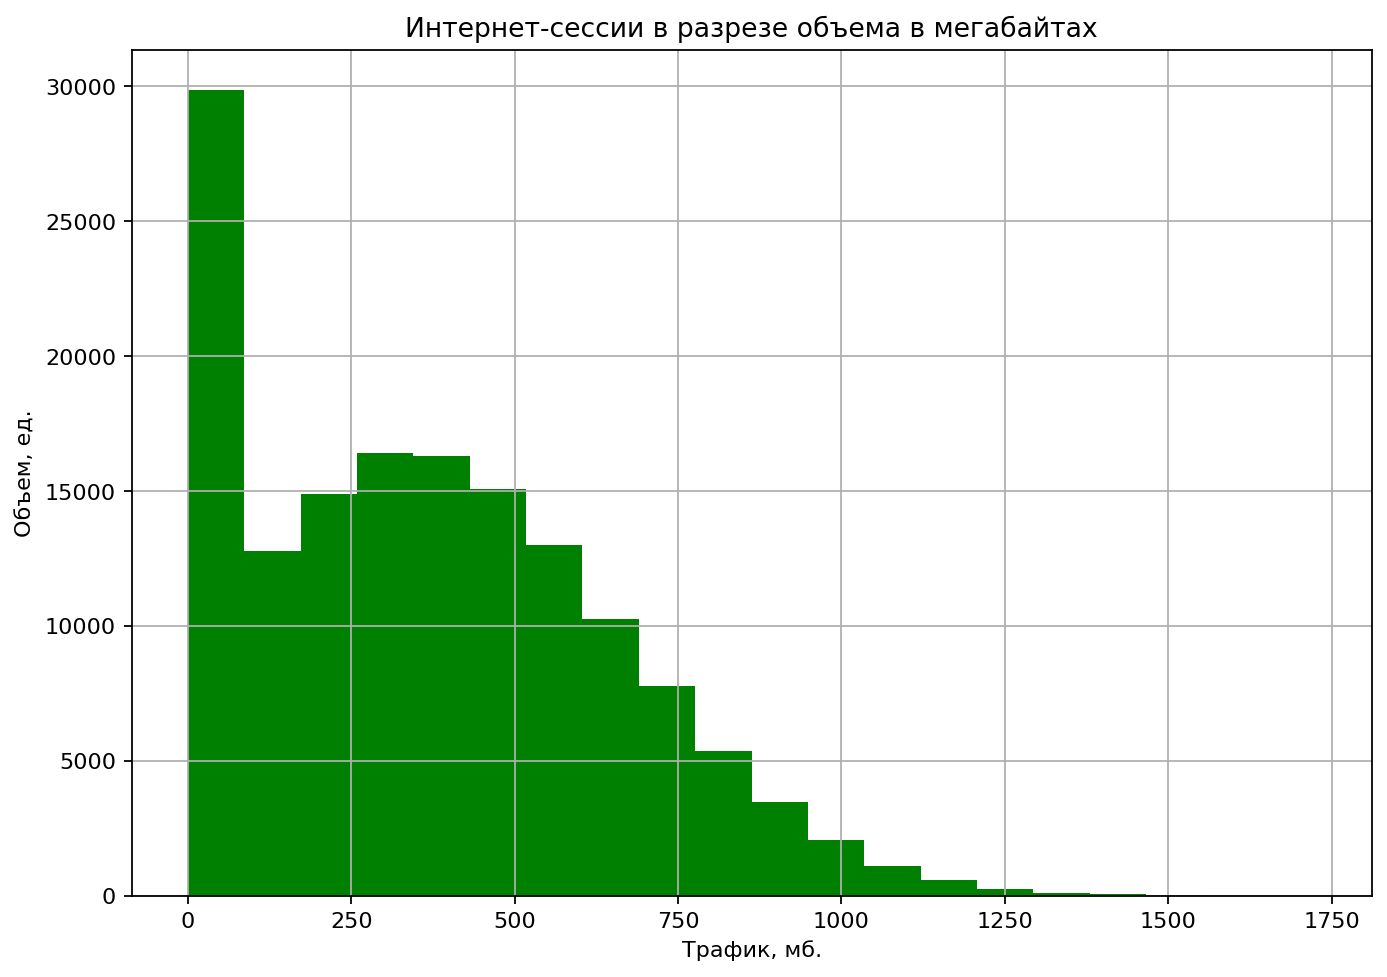

In [13]:
draw_hist(internet['mb_used'], bins=20, title="Интернет-сессии в разрезе объема в мегабайтах",
         xlabel="Трафик, мб.")

Попробуем посмотреть на график без нулевых передач в интернет-сессиях.

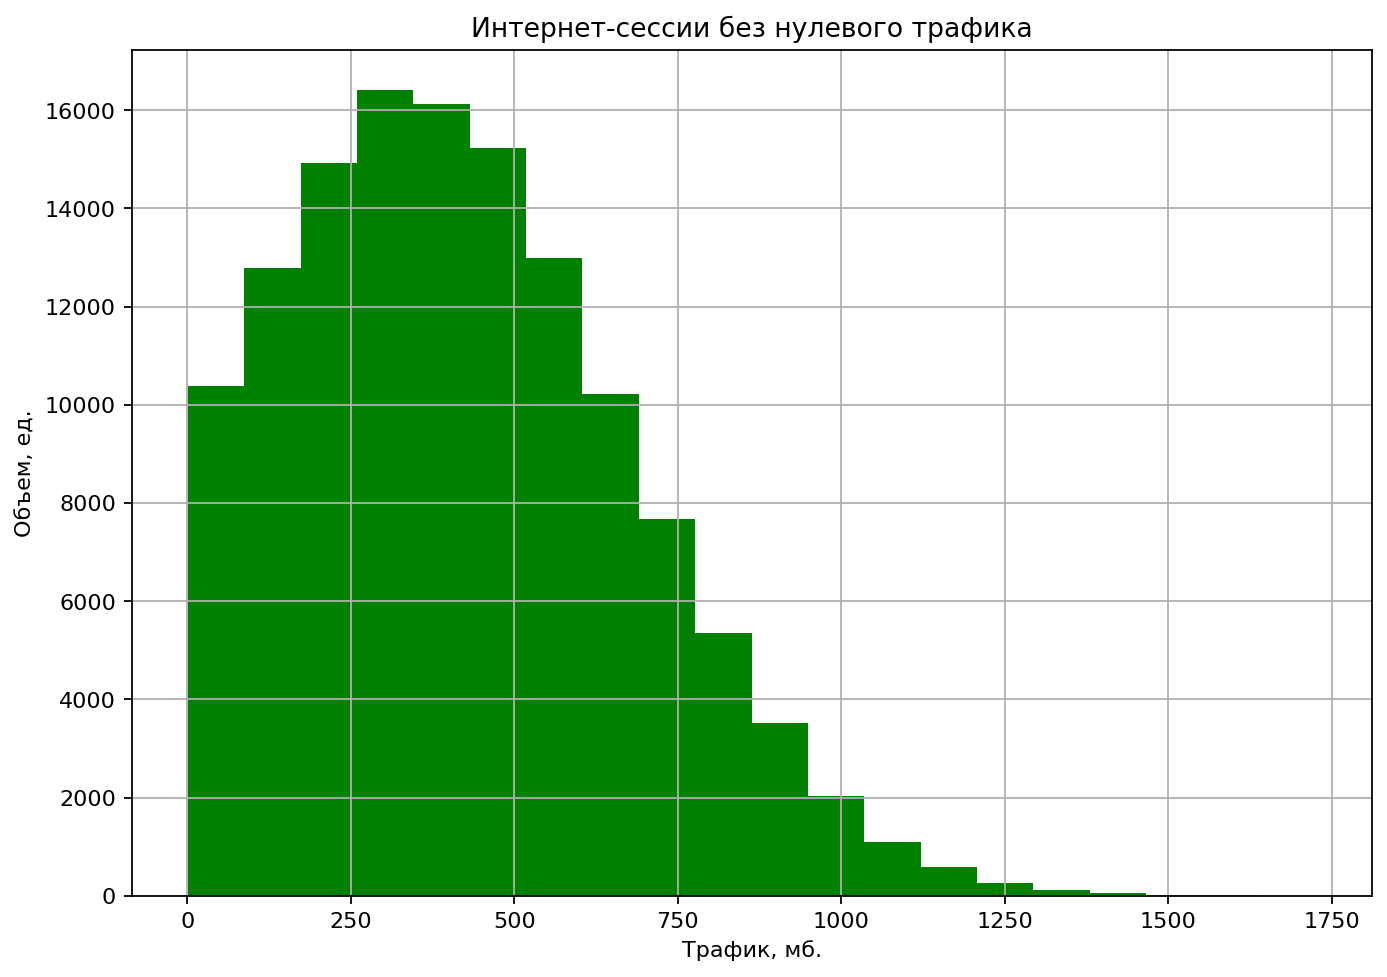

In [14]:
draw_hist(internet.query('mb_used != 0')['mb_used'], bins=20, title="Интернет-сессии без нулевого трафика",
         xlabel="Трафик, мб.")

Получили несимметричное нормальное распределение. Нормально ли это? 

Я думаю, что да: большинство сессий строится по принципу "зайти на сайт и посмотреть информацию" или "поискать информацию". Такие действия не требуют большого объема трафика и при этом - очень популярны. 

Поэтому избавимся от нулевых значений.

Для интернета есть ещё вариант округлить значения использованного интернета, но я им не воспользовался, не вижу в этом смысла.

In [15]:
internet = internet.query('mb_used != 0').reset_index(drop=True)
brief(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129797 entries, 0 to 129796
Data columns (total 4 columns):
id              129797 non-null object
mb_used         129797 non-null int64
session_date    129797 non-null datetime64[ns]
user_id         129797 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 4.0+ MB


,id,mb_used,session_date,user_id
0,1000_0,113,2018-11-25,1000
1,1000_2,1198,2018-06-25,1000
2,1000_3,551,2018-08-22,1000
3,1000_4,303,2018-09-24,1000
4,1000_5,400,2018-10-02,1000


Количество дубликатов - 0


Далее рассмотрим датасет со звонками.

In [16]:
display(calls.query('duration == 0'))

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
5,1000_5,2018-11-02,0,1000
6,1000_6,2018-10-18,0,1000
9,1000_9,2018-08-15,0,1000
...,...,...,...,...
202590,1499_203,2018-12-03,0,1499
202592,1499_205,2018-10-13,0,1499
202593,1499_206,2018-12-26,0,1499
202594,1499_207,2018-10-28,0,1499


20% всех звонков длятся 0 секунд. Нам дали информацию, что время в минутах всегда округляется в большую сторону. То есть 20% звонков - либо сброшенные, либо не дозвонившиеся. 

Это интересное явление, у молодежи есть такой оборот "скинуть бомжа" - когда у тебя нет денег, и ты совершаешь звонок длительностью в один гудок, а потом сбрасываешь. 

С учетом того, какими данными мы обладаем, сложно понять природу таких звонков. Поэтому мысленно для себя учтем эти звонки как недозвон. Посмотрим, как распределены эти звонки. в наших данных.

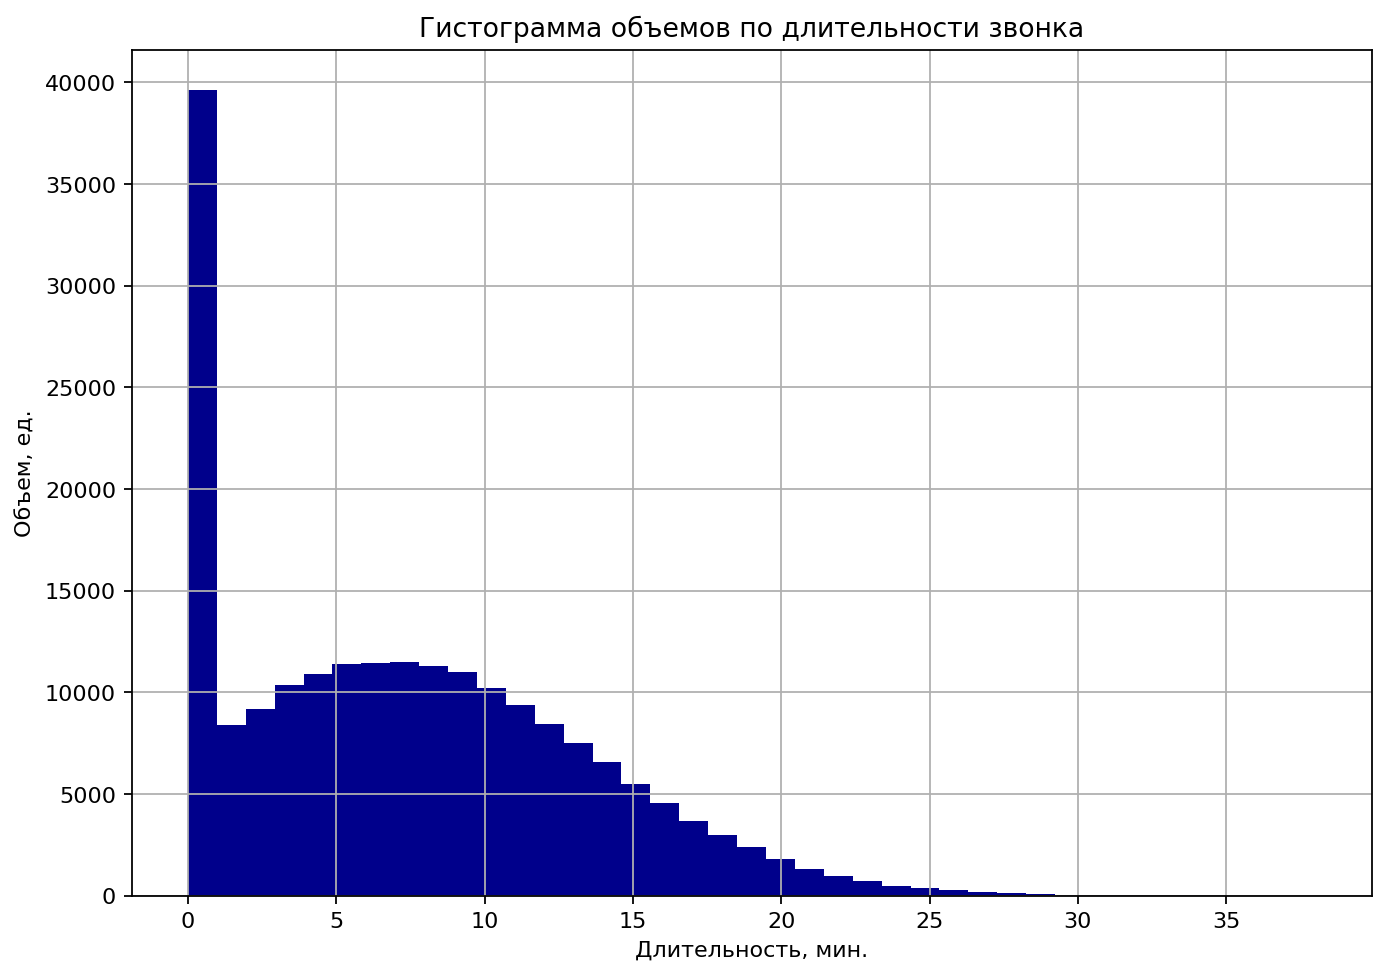

In [17]:
draw_hist(calls['duration'], bins=calls['duration'].max()+1,title="Гистограмма объемов по длительности звонка",
         xlabel="Длительность, мин.", color='darkblue')

Если мы будем работать с данными, то звонки длительностью в 0 минут дадут очень сильный перекос.
Посмотрим на данные без нулевых значений.

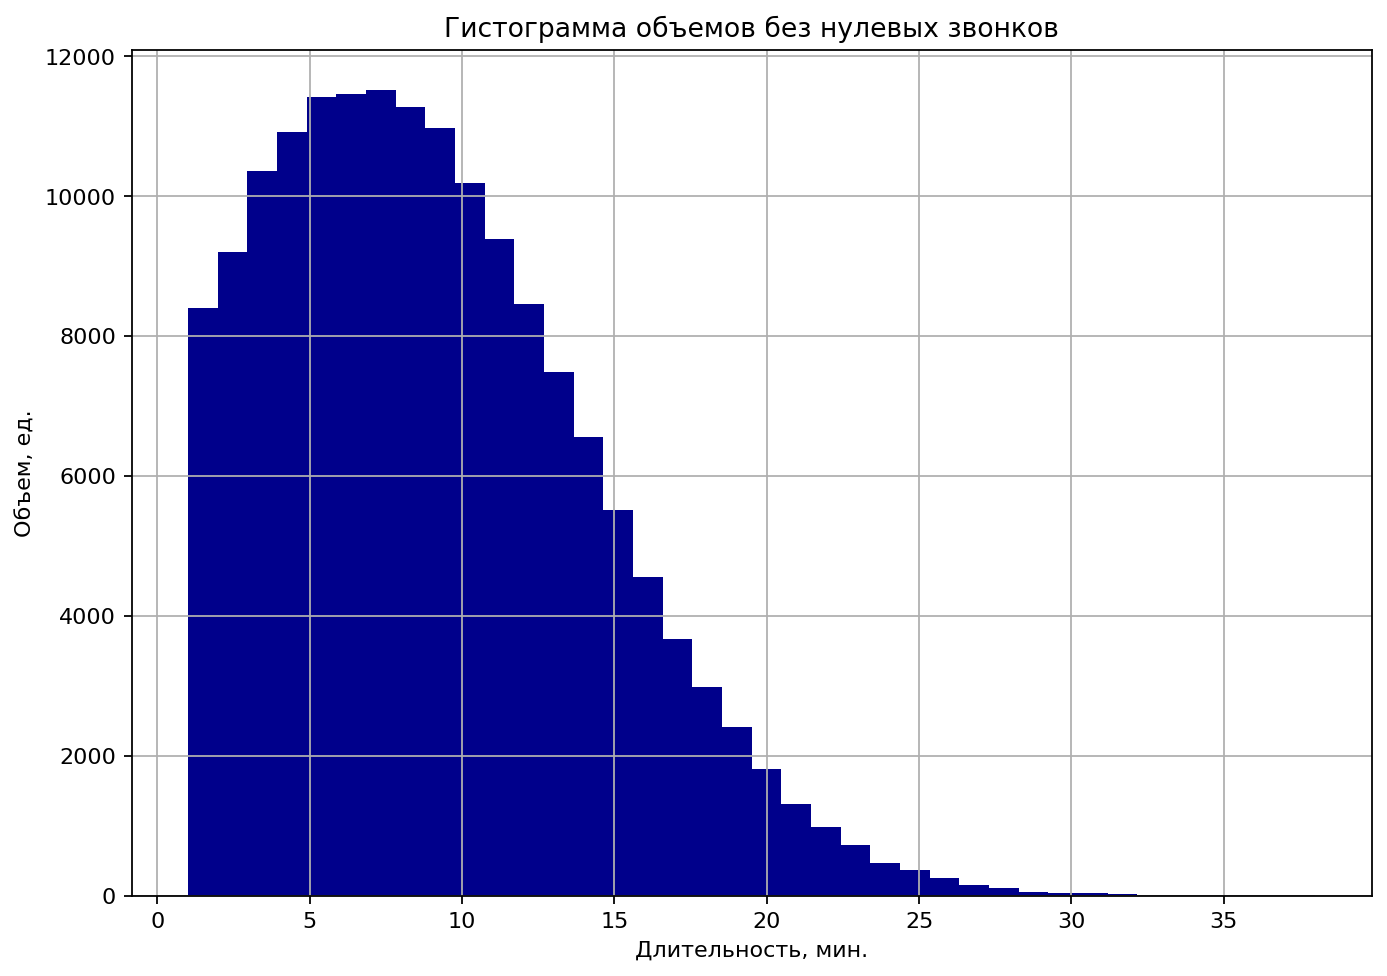

In [18]:
draw_hist(calls.query('duration != 0')['duration'], bins=calls['duration'].max(),title="Гистограмма объемов без нулевых звонков",
         xlabel="Длительность, мин.", color='darkblue')

Здесь также наблюдается нормальное распределение. Сбросим нулевые значения.

In [19]:
calls = calls.query('duration !=0').reset_index(drop=True)
brief(calls)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162994 entries, 0 to 162993
Data columns (total 4 columns):
id           162994 non-null object
call_date    162994 non-null datetime64[ns]
duration     162994 non-null int64
user_id      162994 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 5.0+ MB


,id,call_date,duration,user_id
0,1000_2,2018-06-11,3,1000
1,1000_3,2018-09-21,14,1000
2,1000_4,2018-12-15,6,1000
3,1000_7,2018-08-22,19,1000
4,1000_8,2018-09-15,19,1000


Количество дубликатов - 0


## Преобразование данных

### Количество отправленных сообщений по месяцам

Добавим количество отправленных сообщений по месяцам для пользователей.

In [20]:
messages['month'] = messages['message_date'].dt.month
g_messages = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
g_messages.columns = ['message_count']
g_messages = g_messages.reset_index(drop=False)
display(g_messages)

,user_id,month,message_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


Мы создали сводную таблицу, в которой есть информация по ID пользователя, месяцу и количеству СМС. В настоящий момент мы больше ничего не можем сделать, поэтому переходим к следующей задаче.

### Количество сделанных звонков и израсходованных минут разговора по месяцам

Добавим количество звонков и израсходованных минут для каждого пользователя.

In [21]:
calls['month'] = calls['call_date'].dt.month

calls_pivot = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count', 'sum'])
calls_pivot.columns = ['calls_count', 'calls_duration' ]
calls_pivot = calls_pivot.reset_index(drop=False)
display(calls_pivot)

,user_id,month,calls_count,calls_duration
0,1000,5,17,159
1,1000,6,28,172
2,1000,7,41,340
3,1000,8,42,408
4,1000,9,46,466
...,...,...,...,...
3163,1498,10,30,247
3164,1499,9,8,70
3165,1499,10,44,449
3166,1499,11,62,612


Проведем ту же проверку на NaN.

### Объем израсходованного интернет-трафика по месяцам 

Посчитаем объем израсходованного интернет-трафика по месяцам

In [22]:
internet['month'] = internet['session_date'].dt.month
brief(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129797 entries, 0 to 129796
Data columns (total 5 columns):
id              129797 non-null object
mb_used         129797 non-null int64
session_date    129797 non-null datetime64[ns]
user_id         129797 non-null int64
month           129797 non-null int64
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 5.0+ MB


,id,mb_used,session_date,user_id,month
0,1000_0,113,2018-11-25,1000,11
1,1000_2,1198,2018-06-25,1000,6
2,1000_3,551,2018-08-22,1000,8
3,1000_4,303,2018-09-24,1000,9
4,1000_5,400,2018-10-02,1000,10


Количество дубликатов - 0


In [23]:
internet_pivot = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
internet_pivot = internet_pivot.reset_index(drop=False)

display(internet_pivot)

,user_id,month,mb_used
0,1000,5,2256
1,1000,6,23257
2,1000,7,14016
3,1000,8,14070
4,1000,9,13528
...,...,...,...
3196,1498,10,20604
3197,1499,9,1848
3198,1499,10,17809
3199,1499,11,17984


### Промежуточные выводы

В ходе проведения пунктов 4.1 - 4.3 были получены помесячные сведения по интернет-трафику, количеству смс и звонков, а также длительности звонков. Эти данные были не сразу добавлены в основной датафрейм по причине того, что мне кажется, что прозрачнее добавлять их в едином пункте.

В результате черновых выкладок были получены сведения о том, что у некоторых пользователей либо не было звонков, либо СМС. В следующем пункте нам предстоит встретиться с этой проблемой.

### Рассчет помесячной выручки с каждого пользователя.

Начнем расчет помесячной выручки с каждого пользователя издалека: у нас есть множество датафреймов, которые необходимо объединить, получив единый массив. Для выполнения данной задачи можно начать поочередно объединять датафреймы с users. 

Но тут возникнет проблема, в определенный момент для некоторых пользователей обнаружится следующее: в ходе первого объединения никакой информации о, допустим, 4-ом месяце не было. Но в следующей итерации объединения есть информация. 

Что мы получим? Если такая ситуация возникнет, то нам не избежать полей NaN в левой части после объединения. Да, это не критично, можно восстановить информацию по user_id. Но есть возможность избежать эту неприятную ситуацию - добавим сразу все месяцы для пользователей, а потом вычтем только те, где во всех трёх видах данных (смс, звонки и интернет) значение NaN.

In [24]:
every_sol = [(x, y) for x in users['user_id'] for y in range(1,13)]

all_month_ids = pd.DataFrame(every_sol)
all_month_ids.columns = ['user_id', 'month']
brief(all_month_ids)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 2 columns):
user_id    6000 non-null int64
month      6000 non-null int64
dtypes: int64(2)
memory usage: 93.9 KB


,user_id,month
0,1000,1
1,1000,2
2,1000,3
3,1000,4
4,1000,5


Количество дубликатов - 0


In [25]:
users = users.merge(all_month_ids, on='user_id')

In [26]:
users = users.merge(calls_pivot,on=['user_id', 'month'], how='outer')

In [27]:
users = users.merge(internet_pivot, on = ['user_id', 'month'], how='outer')

In [28]:
users = users.merge(g_messages, on = ['user_id', 'month'], how='outer')

In [29]:
brief(users)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 0 to 5999
Data columns (total 13 columns):
user_id           6000 non-null int64
age               6000 non-null int64
churn_date        456 non-null datetime64[ns]
city              6000 non-null object
first_name        6000 non-null object
last_name         6000 non-null object
reg_date          6000 non-null datetime64[ns]
tariff            6000 non-null object
month             6000 non-null int64
calls_count       3168 non-null float64
calls_duration    3168 non-null float64
mb_used           3201 non-null float64
message_count     2717 non-null float64
dtypes: datetime64[ns](2), float64(4), int64(3), object(4)
memory usage: 656.2+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,calls_count,calls_duration,mb_used,message_count
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,NaN,NaN,NaN,NaN
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2,NaN,NaN,NaN,NaN
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,3,NaN,NaN,NaN,NaN
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,4,NaN,NaN,NaN,NaN
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,17.0,159.0,2256.0,22.0


Количество дубликатов - 0


In [30]:
users = users[~users[['calls_count', 'mb_used', 'message_count']].isna().all(1)]

display(users)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,calls_count,calls_duration,mb_used,message_count
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,17.0,159.0,2256.0,22.0
5,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6,28.0,172.0,23257.0,60.0
6,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7,41.0,340.0,14016.0,75.0
7,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8,42.0,408.0,14070.0,81.0
8,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9,46.0,466.0,13528.0,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5985,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,10,30.0,247.0,20604.0,42.0
5996,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,9,8.0,70.0,1848.0,11.0
5997,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,10,44.0,449.0,17809.0,48.0
5998,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,11,62.0,612.0,17984.0,59.0


Получили датафрейм, содержащий хотя бы одно значение в полях, связанных со звонками, смс и интернетом. Далее заполним пропуски в в этих полях.

In [31]:
users['calls_count'] = users['calls_count'].fillna(0)
users['calls_duration'] = users['calls_duration'].fillna(0)
users['mb_used'] = users['mb_used'].fillna(0)
users['message_count'] = users['message_count'].fillna(0)
brief(users)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 4 to 5999
Data columns (total 13 columns):
user_id           3214 non-null int64
age               3214 non-null int64
churn_date        187 non-null datetime64[ns]
city              3214 non-null object
first_name        3214 non-null object
last_name         3214 non-null object
reg_date          3214 non-null datetime64[ns]
tariff            3214 non-null object
month             3214 non-null int64
calls_count       3214 non-null float64
calls_duration    3214 non-null float64
mb_used           3214 non-null float64
message_count     3214 non-null float64
dtypes: datetime64[ns](2), float64(4), int64(3), object(4)
memory usage: 351.5+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,calls_count,calls_duration,mb_used,message_count
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,17.0,159.0,2256.0,22.0
5,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6,28.0,172.0,23257.0,60.0
6,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7,41.0,340.0,14016.0,75.0
7,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8,42.0,408.0,14070.0,81.0
8,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9,46.0,466.0,13528.0,57.0


Количество дубликатов - 0


Теперь рассчитаем выручку с каждого пользователя.

In [32]:
def monthly_income(row):
    income = 0
    if row['tariff'] == 'ultra':
        income+= 1950
        if row['calls_duration'] > 3000:
            income = income + (row['calls_duration'] - 3000) * 1
        if row['mb_used'] > 30*1024:
            income = income + math.ceil((row['mb_used'] - 30 * 1024)/1024) * 150
        if row['message_count'] > 1000:
            income =income +  (row['message_count'] - 1000) * 1 
    if row['tariff'] == 'smart':
        income+= 550
        if row['calls_duration'] > 500:
            income = income + (row['calls_duration'] - 500) * 3
        if row['mb_used'] > 15*1024:
            income = income + math.ceil((row['mb_used'] - 15 * 1024)/1024) * 200
        if row['message_count'] > 50:
            income =income +  (row['message_count'] - 50) * 3   
    return income

In [33]:
users['m_income'] = users.apply(monthly_income, axis=1)

In [34]:
display(users.head(15))

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,calls_count,calls_duration,mb_used,message_count,m_income
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,17.0,159.0,2256.0,22.0,1950.0
5,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6,28.0,172.0,23257.0,60.0,1950.0
6,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7,41.0,340.0,14016.0,75.0,1950.0
7,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8,42.0,408.0,14070.0,81.0,1950.0
8,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9,46.0,466.0,13528.0,57.0,1950.0
9,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,10,44.0,350.0,14717.0,73.0,1950.0
10,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,11,37.0,338.0,14768.0,58.0,1950.0
11,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12,38.0,333.0,9827.0,70.0,1950.0
22,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,11,45.0,430.0,18452.0,0.0,1350.0
23,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,12,47.0,414.0,14053.0,0.0,550.0


Теперь получим таблицу с общей прибылью по пользователю.

In [35]:
users_income = users.pivot_table(index='user_id', values='m_income', aggfunc='sum')
display(users_income)

,m_income
user_id,
1000,15600.0
1001,1900.0
1002,7250.0
1003,9750.0
1004,15600.0
...,...
1495,11550.0
1496,28551.0
1497,2785.0


Потеряли 2 человек, что же с ними случилось?

Оказалось, что у нас было 2 пользователя с id 1128 и 1371, которые зарегистрировали с их тарифом в декабре и спустя небольшое время отказались от пользования, даже и не попробовав. В связи с этим, у них во всех разделах были NaN.

### Вывод по разделу

В данном разделе были получены данные, необходимые для анализа тарифов. В итоге мы имеем единый датафрейм, в котором имеется вся информация по пользователям, а также помесячные значения звонков, сообщений и использования интернет-трафика. На основании этих данных мы получили необходимую информацию, которая пригодна к дальнейшему анализу.

## Анализ данных в разрезе по тарифам

Шаг 3. Проанализируйте данные
Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения

### Получение сводной таблицы по пользователям

Для начала получим единую сводную таблицу, в которой сохраним необходимую для анализа информацию. Нас не интересует информация по ежемесячной динамике, поэтому не имеет смысла работать с датафреймом users в данном виде.

In [36]:
'''df = users.pivot_table(index=['user_id', 'tariff', 'city'], values=['calls_count','calls_duration','mb_used', 
                                                'message_count', 'm_income'], aggfunc='mean')
df = df.reset_index(drop=False)'''

"df = users.pivot_table(index=['user_id', 'tariff', 'city'], values=['calls_count','calls_duration','mb_used', \n                                                'message_count', 'm_income'], aggfunc='mean')\ndf = df.reset_index(drop=False)"

In [37]:
df = users
brief(df)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 4 to 5999
Data columns (total 14 columns):
user_id           3214 non-null int64
age               3214 non-null int64
churn_date        187 non-null datetime64[ns]
city              3214 non-null object
first_name        3214 non-null object
last_name         3214 non-null object
reg_date          3214 non-null datetime64[ns]
tariff            3214 non-null object
month             3214 non-null int64
calls_count       3214 non-null float64
calls_duration    3214 non-null float64
mb_used           3214 non-null float64
message_count     3214 non-null float64
m_income          3214 non-null float64
dtypes: datetime64[ns](2), float64(5), int64(3), object(4)
memory usage: 376.6+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,calls_count,calls_duration,mb_used,message_count,m_income
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,17.0,159.0,2256.0,22.0,1950.0
5,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6,28.0,172.0,23257.0,60.0,1950.0
6,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7,41.0,340.0,14016.0,75.0,1950.0
7,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8,42.0,408.0,14070.0,81.0,1950.0
8,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9,46.0,466.0,13528.0,57.0,1950.0


Количество дубликатов - 0


Также напишем небольшую функцию по интересующим нас значениям - среднему, дисперсии и стандартному отклонению, чтобы пользоваться ей в дальнейшем.

In [38]:
def brief_stats(series):
    print('Среднее значение - {}'.format(series.mean()))
    print('Дисперсия - {}'.format(np.var(series)))
    print('Нормальное отклонение - {}'.format(np.std(series)))

### Анализ тарифов

In [39]:
smart_users = df.query('tariff == "smart"')
ultra_users = df.query('tariff == "ultra"')
brief(ultra_users)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 985 entries, 4 to 5951
Data columns (total 14 columns):
user_id           985 non-null int64
age               985 non-null int64
churn_date        76 non-null datetime64[ns]
city              985 non-null object
first_name        985 non-null object
last_name         985 non-null object
reg_date          985 non-null datetime64[ns]
tariff            985 non-null object
month             985 non-null int64
calls_count       985 non-null float64
calls_duration    985 non-null float64
mb_used           985 non-null float64
message_count     985 non-null float64
m_income          985 non-null float64
dtypes: datetime64[ns](2), float64(5), int64(3), object(4)
memory usage: 115.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,calls_count,calls_duration,mb_used,message_count,m_income
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,17.0,159.0,2256.0,22.0,1950.0
5,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6,28.0,172.0,23257.0,60.0,1950.0
6,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7,41.0,340.0,14016.0,75.0,1950.0
7,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8,42.0,408.0,14070.0,81.0,1950.0
8,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9,46.0,466.0,13528.0,57.0,1950.0


Количество дубликатов - 0


#### Изучение статистики по звонкам

Для начала рассмотрим статистику по звонкам - здесь предполагается, что различий будет не слишком много.

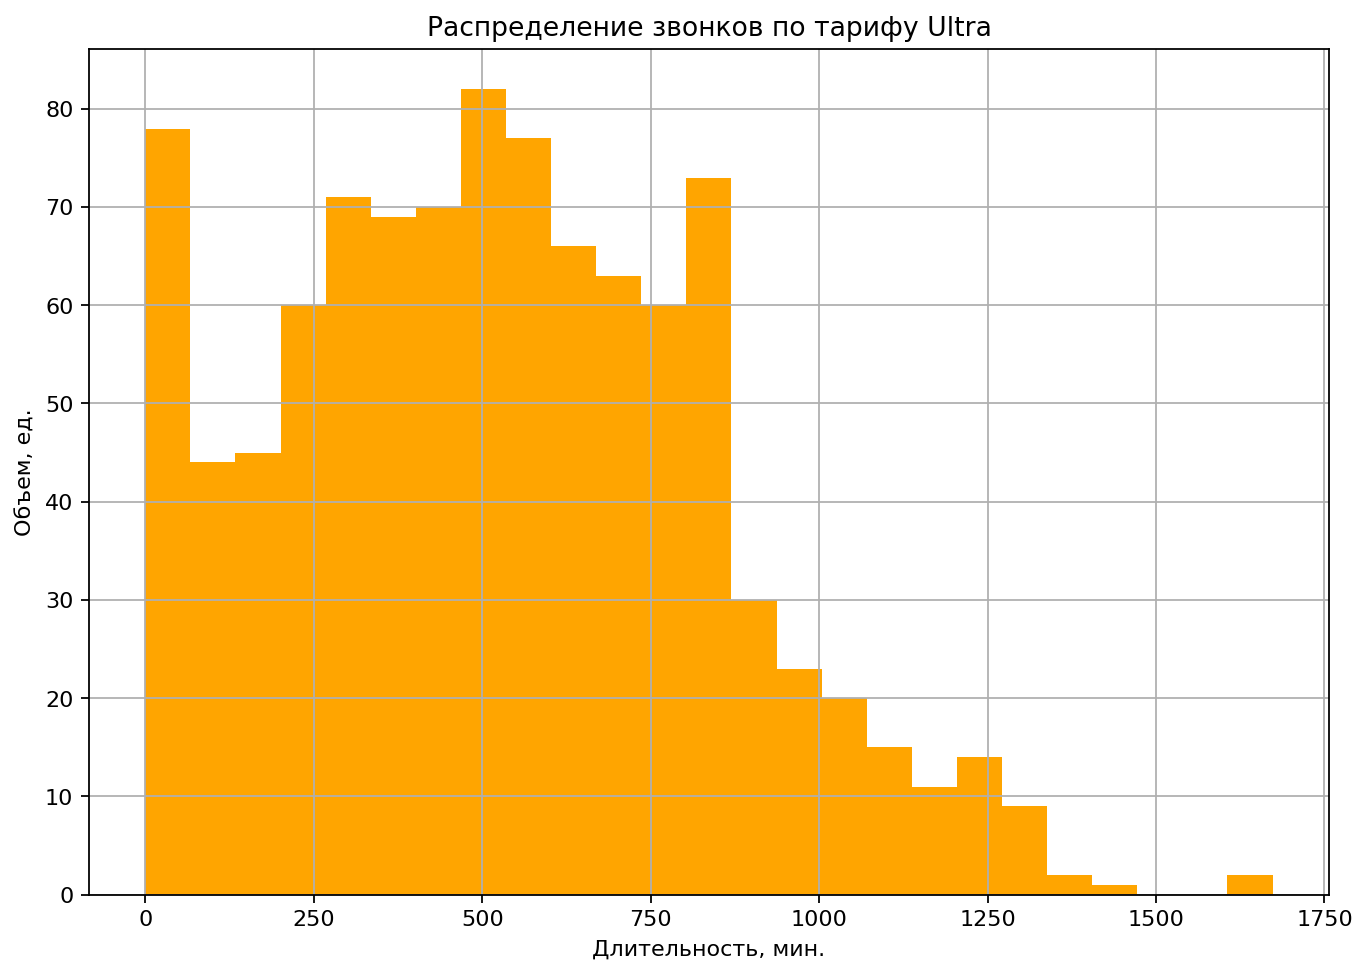

Среднее значение - 526.6233502538071
Дисперсия - 100771.2236172022
Нормальное отклонение - 317.44483554974113


In [40]:
draw_hist(ultra_users['calls_duration'], bins=25,title="Распределение звонков по тарифу Ultra",
         xlabel="Длительность, мин.", color='orange')
brief_stats(ultra_users['calls_duration'])

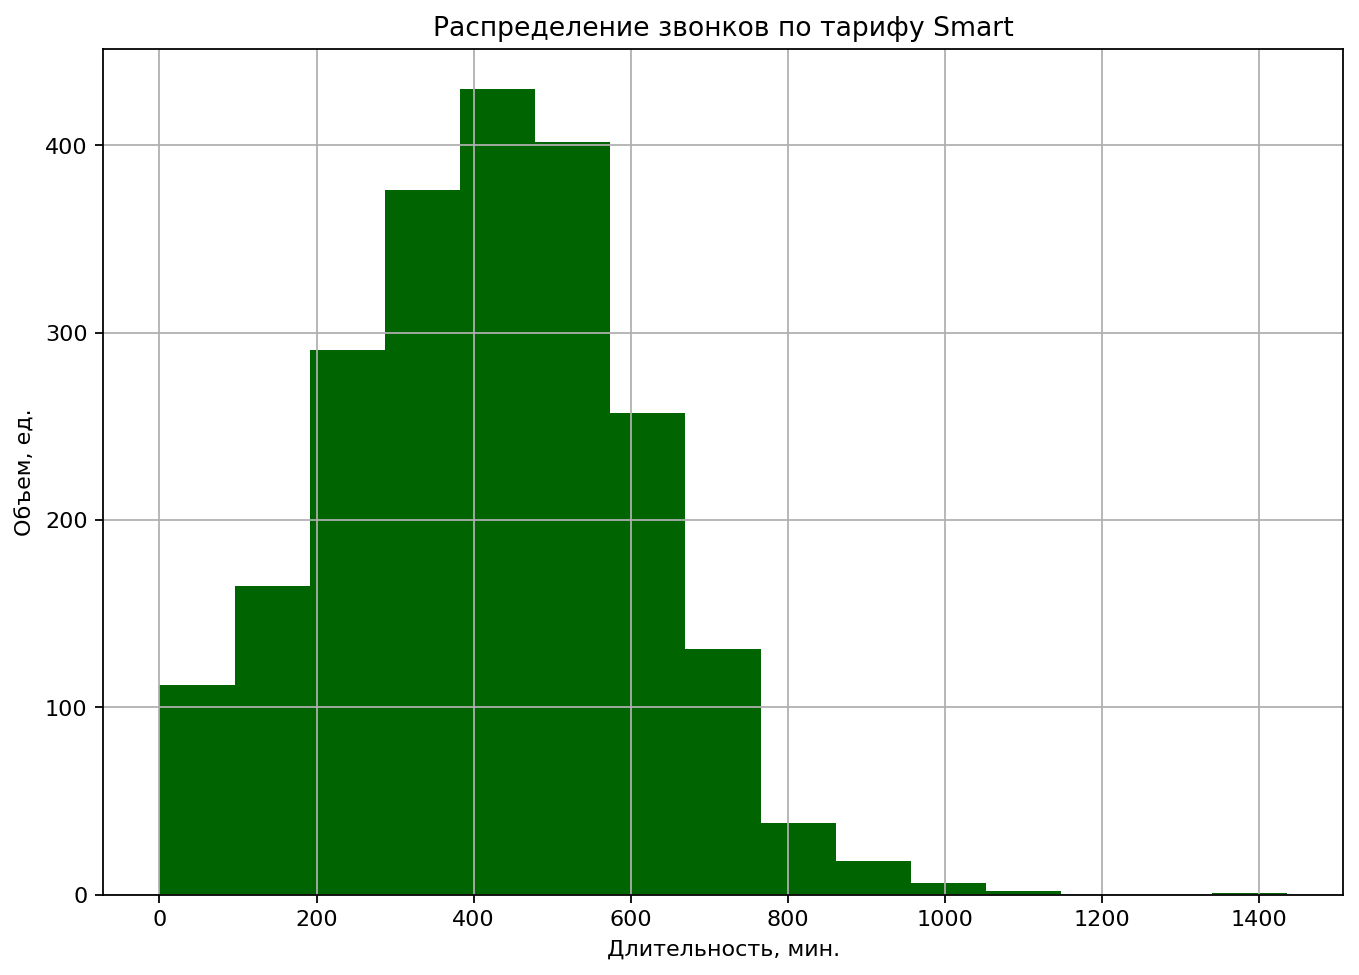

Среднее значение - 417.9349484073576
Дисперсия - 36203.06665209469
Нормальное отклонение - 190.27103471651876


In [41]:
draw_hist(smart_users['calls_duration'], bins=15,title="Распределение звонков по тарифу Smart",
         xlabel="Длительность, мин.", color='darkgreen')
brief_stats(smart_users['calls_duration'])

По графику сразу видим разницу в объеме данных из-за количества абонентов. 350 пользователей тарифа Смарт дают распределение, очень похожее на нормальное.

У тарифа Ультра всё гораздо сложнее - из-за малого объема выборки нормальное распределение не так очевидно. Также видно смещение нормального распределения вправо - довольно большое количество значений лежит в пределах от 0 до 200. 

Отметим сходство графиков - значение отклонения от среднего в -3 сигмы будет меньше нуля. Для нас это значит, что вероятность того, что пользователь потратил 0 минут в среднем за месяц на разговор - не слишком мала, чтобы её не учитывать. Видимо, некоторые пользователи предпочитают и вовсе не пользоваться услугами мобильной телефонной связи. Интересно, что компания может предложить таким пользователям?

Подчеркнем один момент - у тарифа ультра 3000 минут в месяц. Кажется, что это слишком много, лишь единицы в набирают в среднем более 1000 минут в месяц. Но, возможно, здесь дело не в использовании минут, а в брендировании тарифа - ультра предполагает большую стоимость и большие цифры за эту стоимость - так пусть пользователи тарифа радуются осознанию того, что они могут говорить сколько угодно. Интересно следующее - есть ли вообще клиенты 

Наглядно проиллюстрируем различия в распределениях между тарифами.

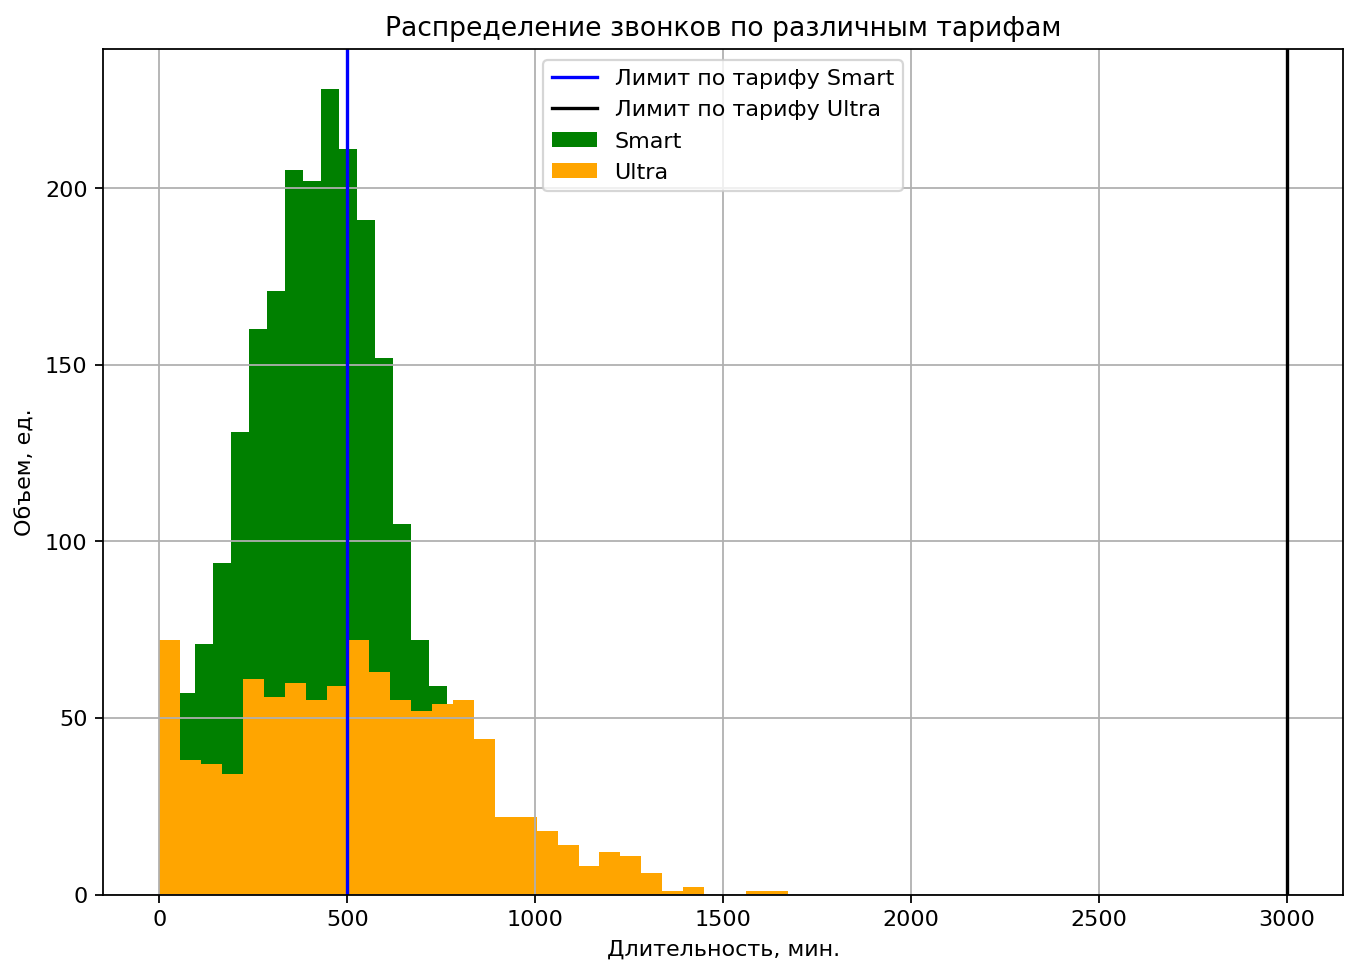

In [42]:
draw_hist_comp(smart_users['calls_duration'], ultra_users['calls_duration'], 
               bins=30,title="Распределение звонков по различным тарифам",
         xlabel="Длительность, мин.", lim_smart = 500, lim_ultra = 3000)

#### Изучение статистики по сообщениям.

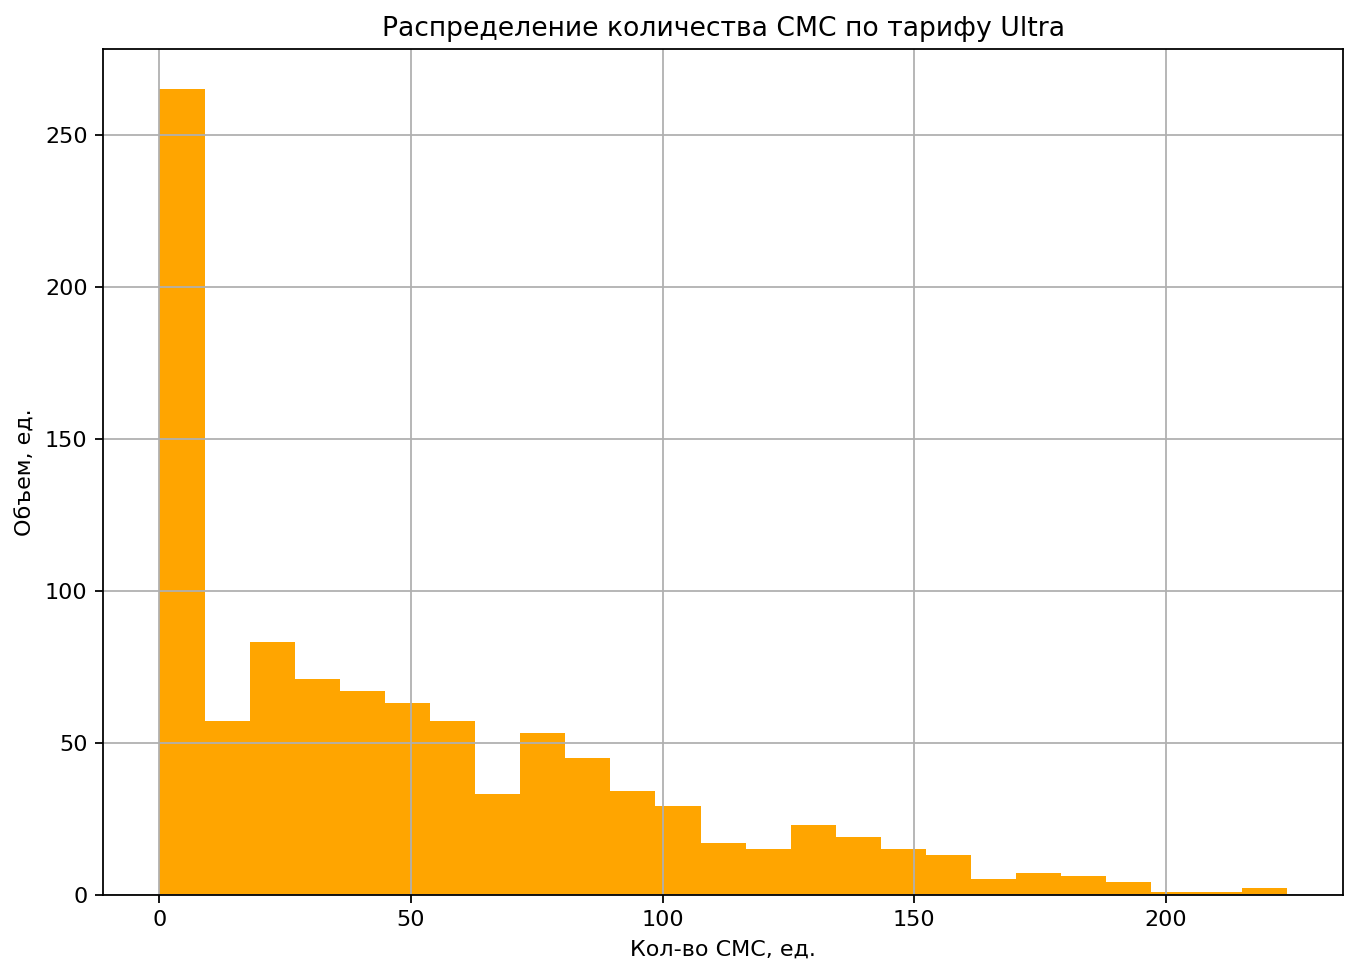

Среднее значение - 49.36345177664975
Дисперсия - 2282.9460753948824
Нормальное отклонение - 47.78018496610161


In [43]:
draw_hist(ultra_users['message_count'], bins=25,title="Распределение количества СМС по тарифу Ultra",
         xlabel="Кол-во СМС, ед.", color='orange')
brief_stats(ultra_users['message_count'])

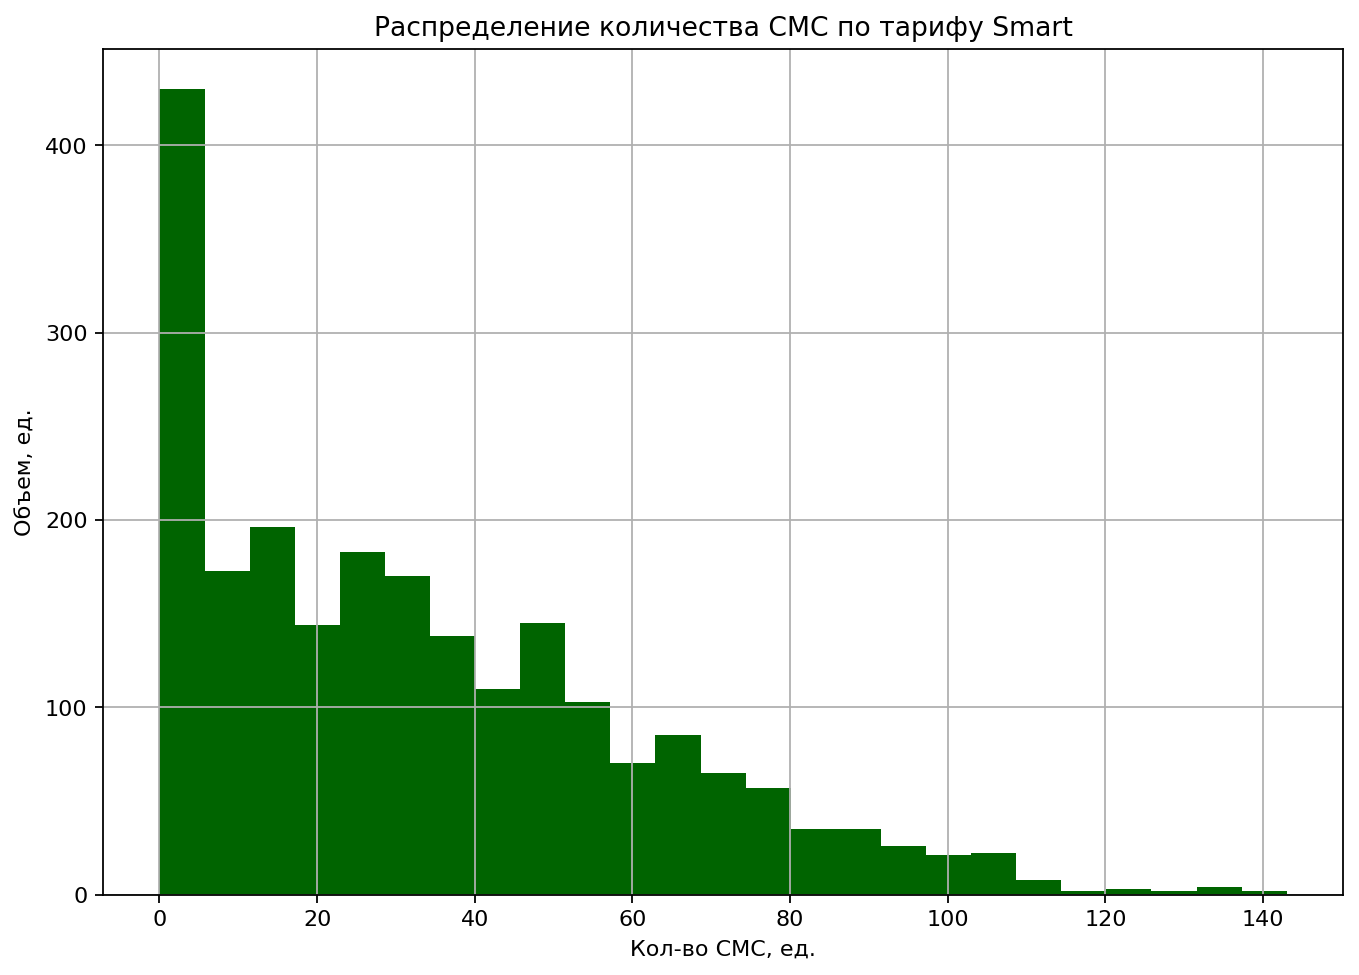

Среднее значение - 33.384028712427096
Дисперсия - 796.455482917076
Нормальное отклонение - 28.221542886898938


In [44]:
draw_hist(smart_users['message_count'], bins=25,title="Распределение количества СМС по тарифу Smart",
         xlabel="Кол-во СМС, ед.", color='darkgreen')
brief_stats(smart_users['message_count'])

На основе анализа информации по СМС-сообщениям видем следующее:

Обе выборки скошены вправо, при этом среднее значение СМС в случае с тарифом Ультра больше, чем у тарифа Смарт.

В остальном - ничего сверхъестественного в распределении не наблюдается. Отметим лишь, что для тарифа ультра ввероятность, что пользователь в будет писать в среднем больше 200 смс в месяц крайне мала. То есть и тут есть такой же момент - верхняя планка тарифа по СМС как-будто бы специально задрана слишком высоко.

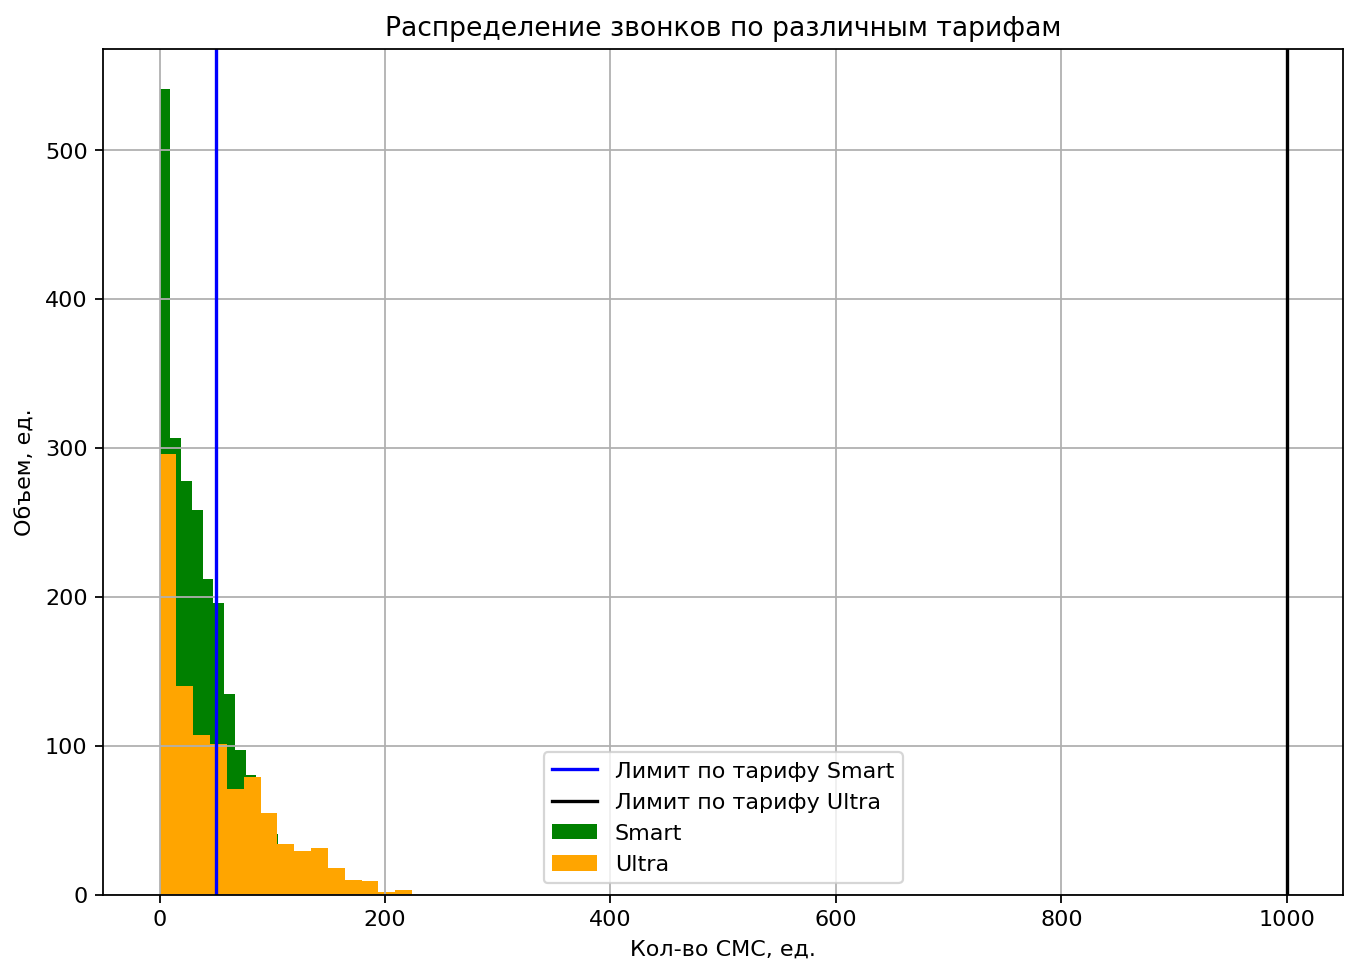

In [45]:
draw_hist_comp(smart_users['message_count'], ultra_users['message_count'], 
               bins=15,title="Распределение звонков по различным тарифам",
         xlabel="Кол-во СМС, ед.", lim_smart = 50, lim_ultra = 1000)

#### Изучение статистики по использованию интернета

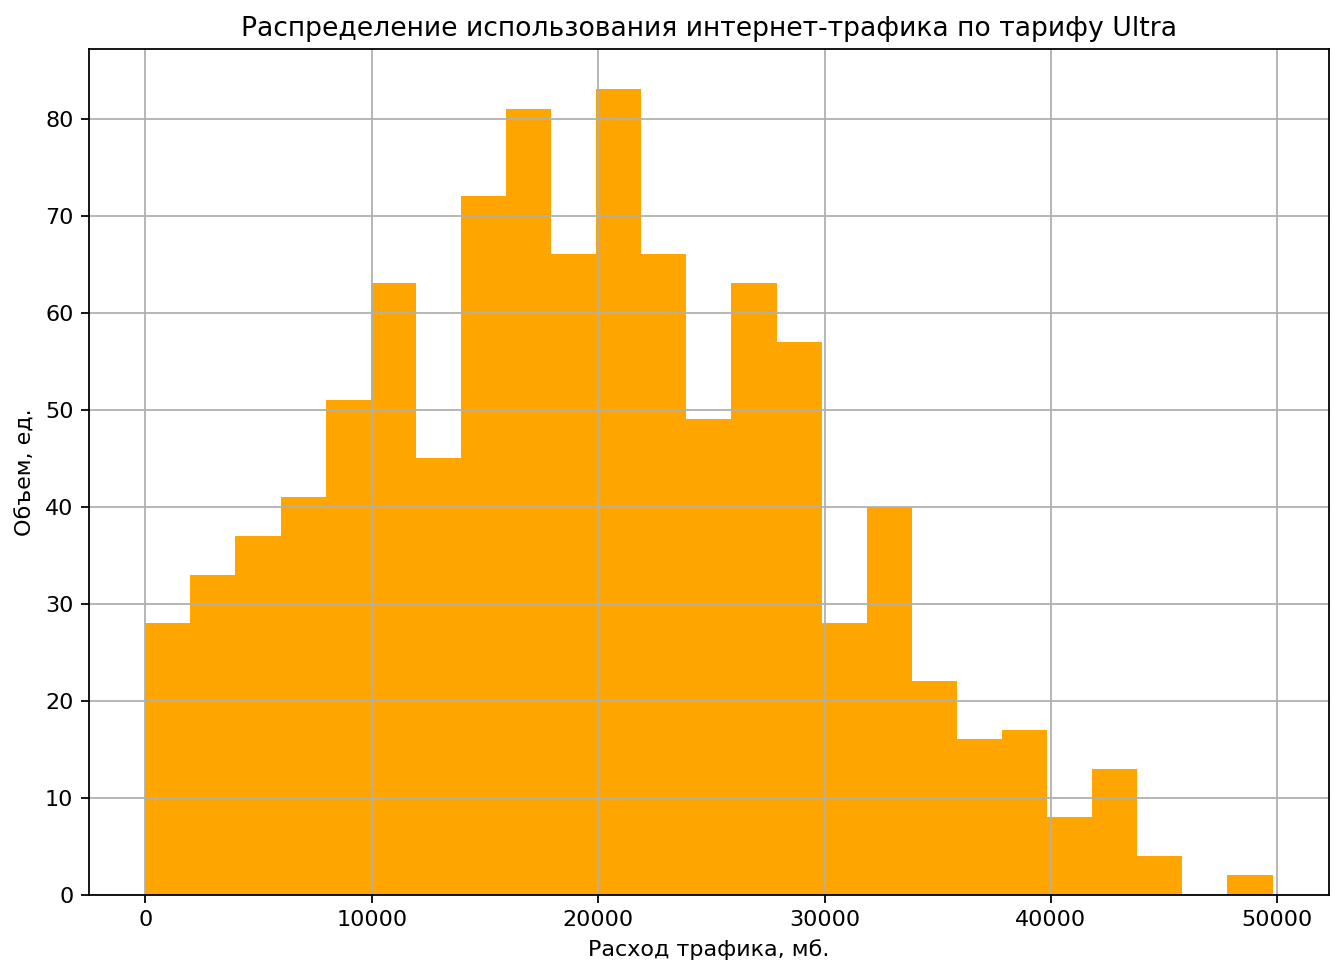

Среднее значение - 19485.832487309646
Дисперсия - 101843746.8257466
Нормальное отклонение - 10091.766288700239


In [46]:
draw_hist(ultra_users['mb_used'], bins=25,title="Распределение использования интернет-трафика по тарифу Ultra",
         xlabel="Расход трафика, мб.", color='orange')
brief_stats(ultra_users['mb_used'])

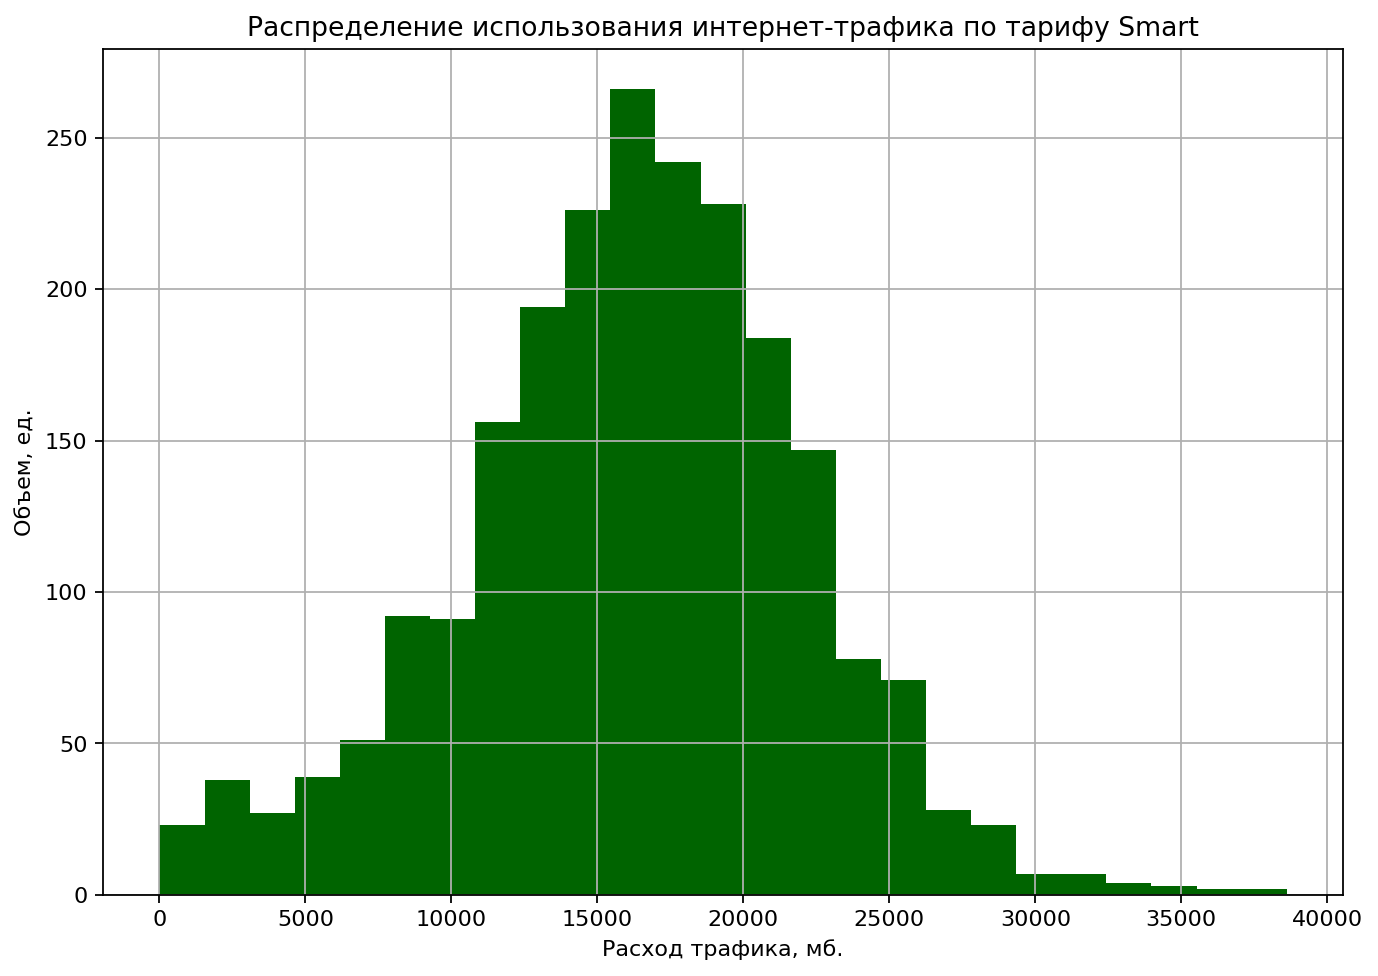

Среднее значение - 16229.188425302826
Дисперсия - 34530412.73703965
Нормальное отклонение - 5876.25839604077


In [47]:
draw_hist(smart_users['mb_used'], bins=25,title="Распределение использования интернет-трафика по тарифу Smart",
         xlabel="Расход трафика, мб.", color='darkgreen')
brief_stats(smart_users['mb_used'])

В случае с интернет трафиком ситуация следующая: 

Пользователи тарифа Смарт в среднем используют 16,1 Гб интернет-трафика в месяц. То есть переплачивают 400 рублей за 2 Гб.
В случае с тарифом Ультра пользователи используют в среднем всего 19 Гб из 30 возможных. Нормальное отклонение для пользователей тарифа Ультра в два раза больше, чем для пользователей тарифа Смарт. Это может быть вызвано тем, что выборка по тарифу Ультра меньше в два раза выборки по тарифу Смарт.

Распределение по выборке из тарифа Ультра немного скошено вправо, в точке, равной нулю, отклонение от среднего значения составляет всего -2,36 сигмы. Получается так, что есть определенная прослойка людей, которым на тарифе Ультра не очень-то и нужен этот интернет.

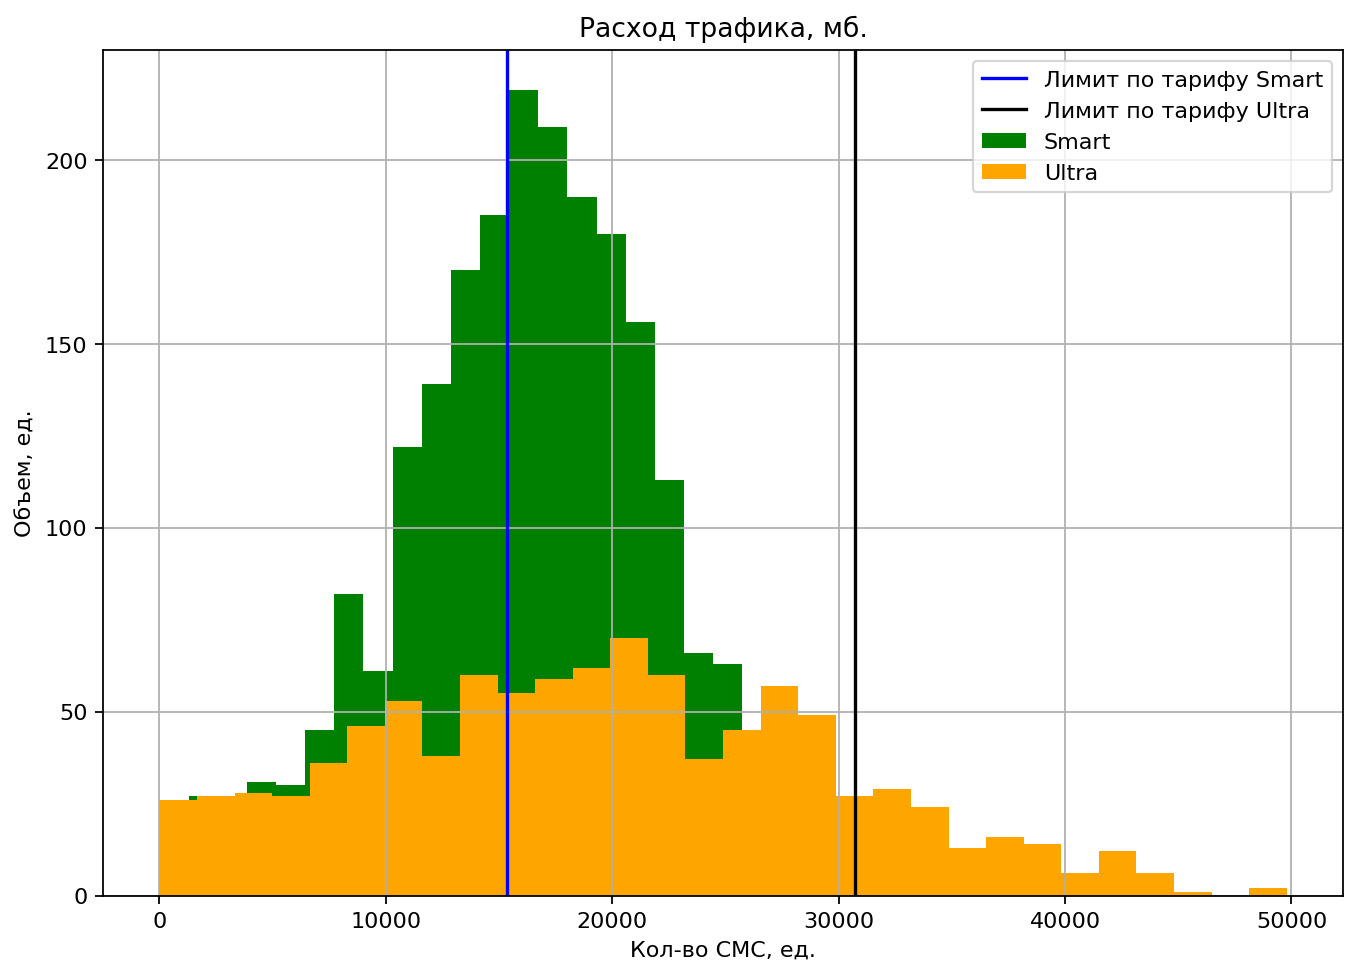

In [48]:
draw_hist_comp(smart_users['mb_used'], ultra_users['mb_used'], 
               bins=30,title="Расход трафика, мб.",
         xlabel="Кол-во СМС, ед.", lim_smart = 15*1024, lim_ultra = 30*1024)

### Вывод

В данном блоке мы ознакомились со статистикой по звонкам, смс и использованию интернет-трафика пользователями разных тарифов.

Несмотря на то, что предоставленные выборки не очень велики, можно сделать некоторые выводы: 

- Пользователи тарифа ультра часто используют свой тариф не по максимуму. Здесь нужно задать вопрос - целесообразно ли ценообразование по данному тарифу? Может быть, стоимость тарифа можно уменьшить вместе с возможностями, чтобы привлечь в него большее количество людей.
 
- Несмотря на это пользователи тарифа Ультра также являются более активными по сравнению с пользоавтелями тарифа Смарт: они больше разговаривают по телефону, пишут СМС и сидят в интернете. 

## Проверка гипотез

Нам даны для проверки 2 гипотезы. Попробуем с ними разобраться.

1) средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;

2) средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;


### Гипотеза 1. Выручка пользователей различается.

Для того, чтобы ответить на данный вопрос, сформулируем <strong>нулевую гипотезу</strong> следующим образом: 

H0 - Средняя выручка пользователей тарифов "Ультра" и "Смарт" равна.

Тогда <strong>альтернативная гипотеза</strong> H1 будет звучать так: средняя выручка пользоавтелей тарифов "Ультра" и "Смарт" различается.

In [49]:
print("Дисперсия по выручке с пользователей тарифа Ultra равна {:.2f}".format(np.var(ultra_users['m_income'])))
print("Дисперсия по выручке с пользователей тарифа Smart равна {:.2f}".format(np.var(smart_users['m_income'])))

Дисперсия по выручке с пользователей тарифа Ultra равна 143345.56
Дисперсия по выручке с пользователей тарифа Smart равна 673628.97


Дисперсии сильно отличаются, учтем это при проверке гипотезы. 

In [50]:
result = st.ttest_ind(smart_users['m_income'], ultra_users['m_income'], equal_var=False)

print('p-значение:', result.pvalue)

if result.pvalue < 0.05:
    print("Отбрасываем нулевую гипотезу, она несостоятельна")
else:
    print('Нулевая гипотеза сработала')

p-значение: 2.7240946993530856e-246
Отбрасываем нулевую гипотезу, она несостоятельна


Нулевая гипотеза не подтвердилась, при этом альтернативная гипотеза по логике является обратной для нулевой. Тогда получается, что альтернативная гипотеза подтверждается.

### Гипотеза 2. Выручка пользователей из Москвы отличается от остальных

<strong>Нулевая гипотеза</strong> в данном случае звучит так:

H0 - Средняя выручка по Москве и другим городам одинакова.

<strong>Альтернативная гипотеза</strong>: 

H1 - Средняя выручка по Москве и другим городам различается

In [51]:
users_moscow = df.query("city == 'Москва'")
users_other = df.query("city != 'Москва'")

print("Дисперсия по выручке с Москвичей равна {:.2f}".format(np.var(users_moscow['m_income'])))
print("Дисперсия по выручке с пользователей прочих городов {:.2f}".format(np.var(users_other['m_income'])))

result = st.ttest_ind(users_moscow['m_income'], users_other['m_income'], equal_var=False)

print('p-значение:', result.pvalue)

if result.pvalue < 0.05:
    print("Отбрасываем нулевую гипотезу, она несостоятельна")
else:
    print('Нулевая гипотеза не опровергнута')

Дисперсия по выручке с Москвичей равна 565256.38
Дисперсия по выручке с пользователей прочих городов 656514.28
p-значение: 0.5126564657748214
Нулевая гипотеза не опровергнута


Не получилось опровергнуть нулевую гипотезу, а это значит, что выручка пользователей из Москвы и других городов примерно совпадает. Построим графики, чтобы наглядно просмотреть этот момент.

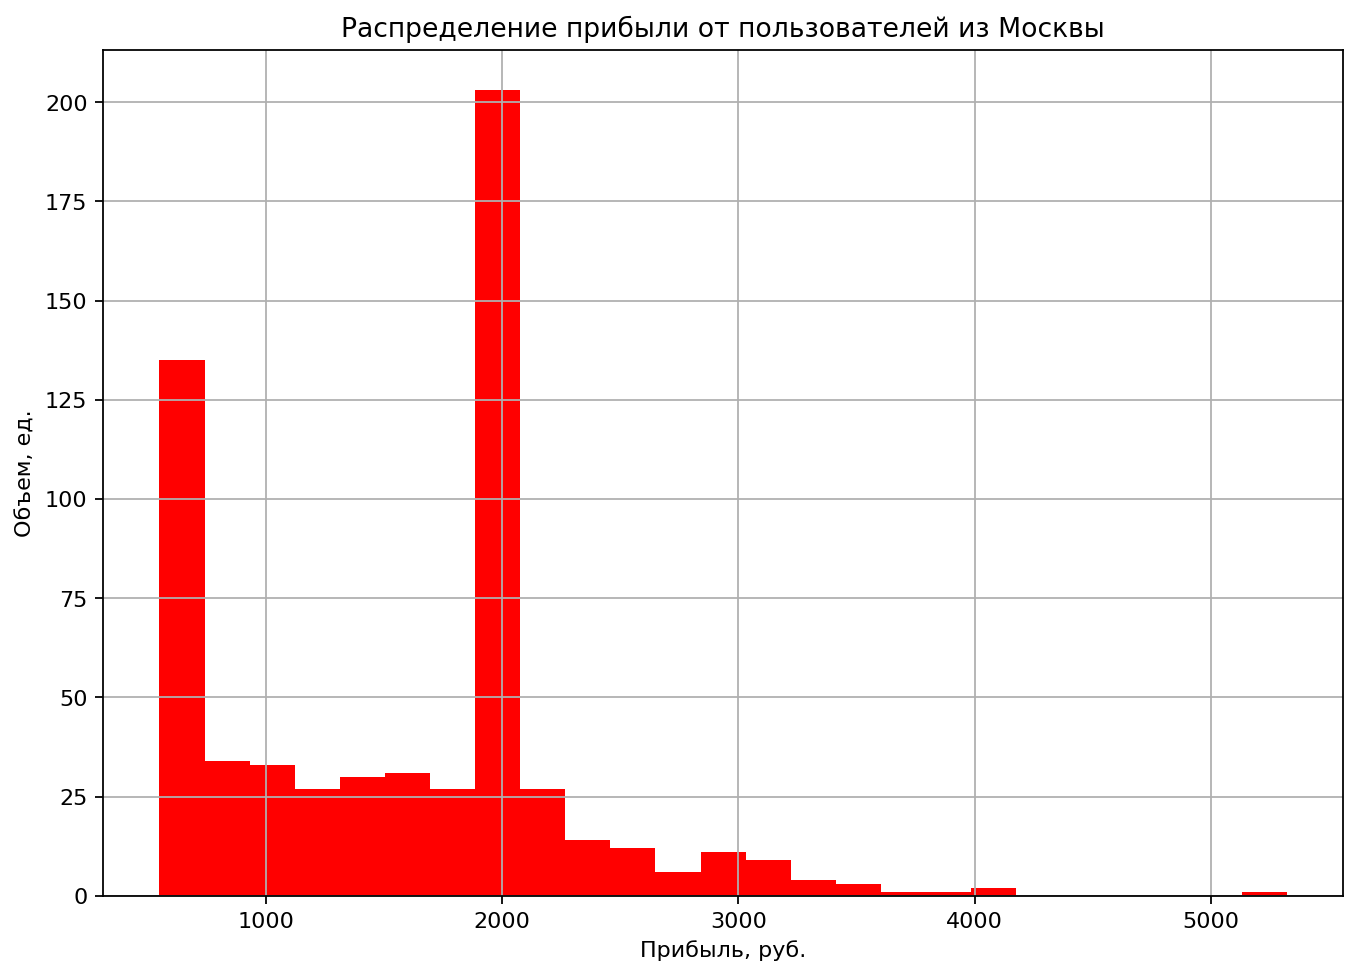

Среднее значение - 1550.8052373158755
Дисперсия - 565256.3794161058
Нормальное отклонение - 751.8353406272585


In [52]:
draw_hist(users_moscow['m_income'], bins=25,title="Распределение прибыли от пользователей из Москвы",
         xlabel="Прибыль, руб.", color='red')
brief_stats(users_moscow['m_income'])

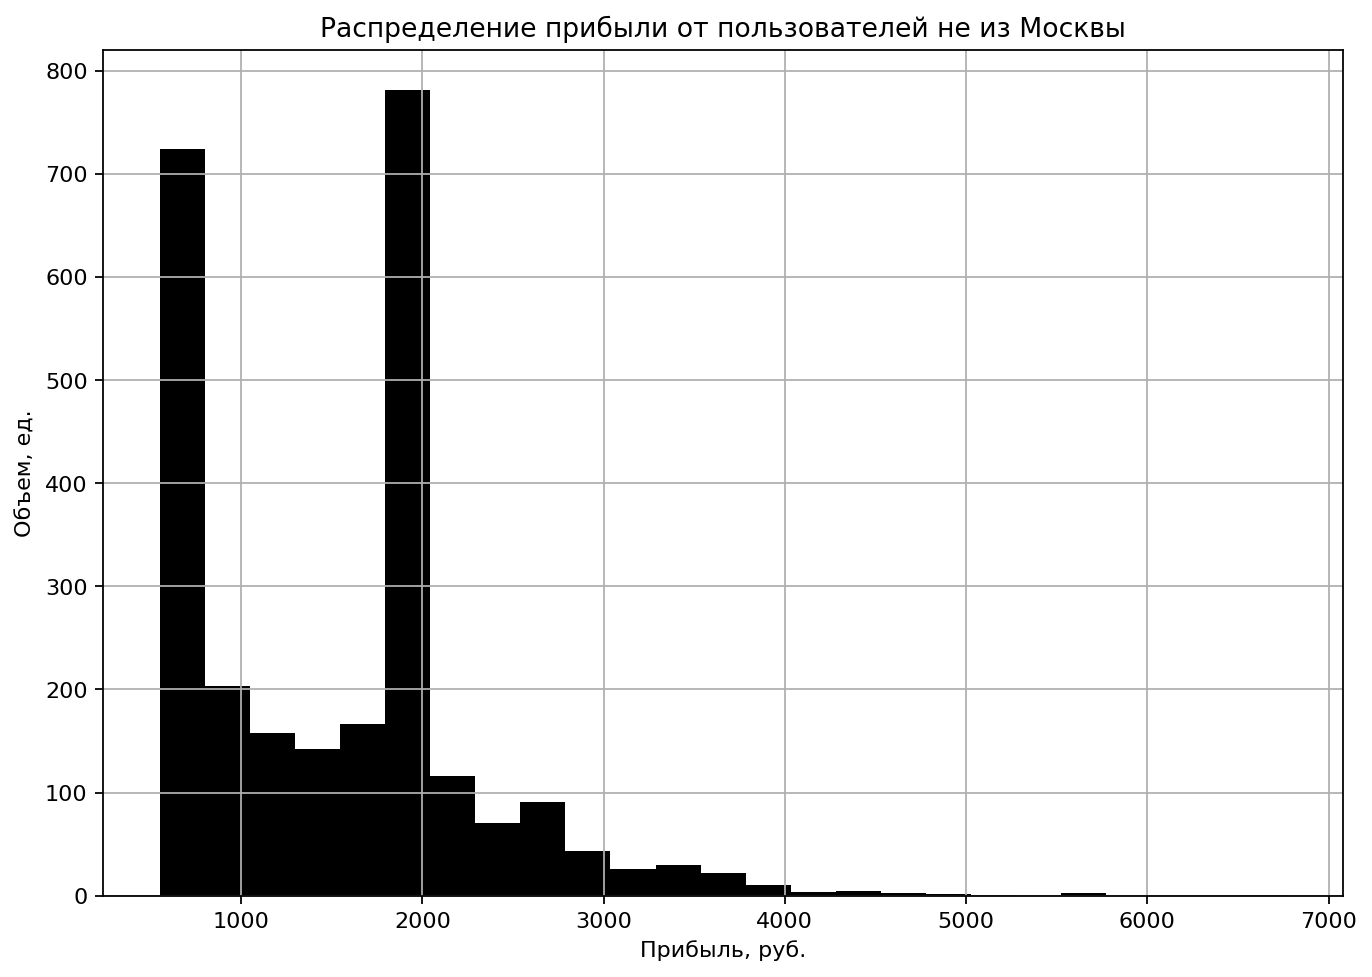

Среднее значение - 1528.3169419900116
Дисперсия - 656514.2841040562
Нормальное отклонение - 810.2556905718442


In [53]:
draw_hist(users_other['m_income'], bins=25,title="Распределение прибыли от пользователей не из Москвы",
         xlabel="Прибыль, руб.", color='black')
brief_stats(users_other['m_income'])

Из данного небольшого анализа видим, что нормальное отклонение и среднее значение примерно равны. А сами графики очень похожи друг на друга!

### Вывод

Рассмотрев 2 гипотезы мы получили следующие выводы:

Первая гипотеза была подтверждена путём опровержения поставленной нулевой гипотезы. Это можно объяснить огромной разницей в стоимости тарифов - 500 и почти 2 тысячи рублей. Да, есть пользователи, которые докупают дополнительно гигабайты, интернет и смс, но они есть везде. 

Вторая гипотеза была опровергнута - распределение прибыли от Москвичей и пользователей из других городов примерно совпадают несмотря на различния в величине выборки. 

## Итого

В данной работе мной была аггрегирована информация по действиям пользователей тарифов компании, а после - проведен анализ. В результате анализа в общем виде были изучены распределения по количеству СМС, продолжительности звонков и размерах интернет-сессий.

После этого был произведен помесячный расчет выручки с пользователей в зависимости от того, какой тариф конкретный пользователь имеет.

Далее было графическое и статистическое сравнение действий пользователей в зависимости от их тарифа. Были сделаны выводы о том, что зачастую пользователи тарифа Ультра не используют свой тариф полностью. Также было отмечено, что в среднем для тарифа ультра пользователи используют 16,1 ГБ интернета в месяц, что равно примерно 400 рублям в месяц.

Далее различия в тарифах и их стоимости были подтверждены предоставленной заданием гипотезой. Действительно, выборки по различным тарифам очень сильно отличаются и по среднему, и по нормальному отклонению.

А в конце была опровергнута гипотеза о различии в выручке с Москвичей и других городов.
